In [1]:
#The dataset was taken from https://www.kaggle.com/c/diabetic-retinopathy-detection
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
#sz=224
sz = 128
arch=resnet34
bs=24

In [4]:
PATH = '/home/ubuntu/fastai/courses/dl1/data/retina/'

In [5]:
df = pd.read_csv(f'{PATH}trainLabels.csv')
print(df.dtypes)
df['level'] = df['level'].apply(lambda x: str(x)+"_")
df.to_csv('labels.csv',index = False)
print(df.dtypes)

image    object
level     int64
dtype: object
image    object
level    object
dtype: object


In [6]:
label_csv = f'{PATH}labels.csv'

#list of rows, minus 1, nubmer of rows in CSV, number of imgs
n = len(list(open(label_csv)))-1

# get crossvalidation indexes custom FASTAI
val_idxs = get_cv_idxs(n)

In [7]:
label_df = pd.read_csv(label_csv)

In [8]:
label_df.pivot_table(index='level', aggfunc=len).sort_values('image', ascending=False)[:10]

,image
level,
0_,25810
2_,5292
1_,2443
3_,873
4_,708


In [9]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpeg', tfms=tfms, bs=bs)

In [10]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [11]:
row_sz, col_sz = list(zip(*size_d.values()))

In [12]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

In [13]:
row_sz[:6]

array([4752, 4752, 3456, 3456, 3888, 3888])

(array([   16.,     0.,   343.,   110.,  6277.,  1738.,  4649.,  8316.,   933.,  5719.]),
 array([  400. ,   878.4,  1356.8,  1835.2,  2313.6,  2792. ,  3270.4,  3748.8,  4227.2,  4705.6,  5184. ]),
 <a list of 10 Patch objects>)

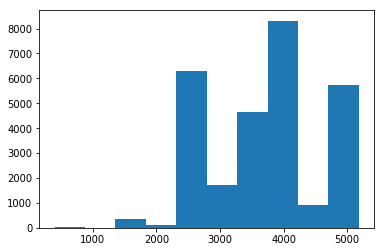

In [14]:
plt.hist(row_sz)

(array([   16.,     0.,   333.,    13.,   160.,  7872.,  4739.,  8316.,   933.,  5719.]),
 array([  289. ,   605.7,   922.4,  1239.1,  1555.8,  1872.5,  2189.2,  2505.9,  2822.6,  3139.3,  3456. ]),
 <a list of 10 Patch objects>)

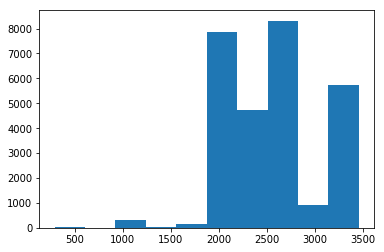

In [15]:
plt.hist(col_sz)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.]),
 array([ 289. ,  291.6,  294.2,  296.8,  299.4,  302. ,  304.6,  307.2,  309.8,  312.4,  315. ]),
 <a list of 10 Patch objects>)

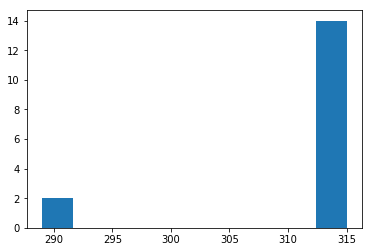

In [16]:
plt.hist(col_sz[col_sz<1000])

In [17]:
len(data.trn_ds), len(data.test_ds)

(28101, 53576)

In [18]:
len(data.classes), data.classes[:5]

(5, ['0_', '1_', '2_', '3_', '4_'])

In [19]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpeg', tfms=tfms, bs=bs)
    #return data if sz < 300 else data.resize(340, 'tmp')
    return data

In [20]:
data = get_data(sz,bs)

In [21]:
learn = ConvLearner.pretrained(arch,data, precompute=True, ps=0.5)

100%|██████████| 2233/2233 [1:16:29<00:00,  2.06s/it]


In [22]:
learn.fit(1e-2,2)

A Jupyter Widget

[ 0.       0.91201  0.85896  0.72434]                           
[ 1.       0.86277  0.83184  0.72505]                           



In [23]:
learn.fit(1e-2,2)

A Jupyter Widget

[ 0.       0.83605  0.82048  0.72704]                           
[ 1.       0.78718  0.81966  0.72823]                           



In [ ]:
#For validation set accuracy
from sklearn import metrics

log_preds,y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)


In [51]:
prob_preds, y= learn.TTA(is_test = True)
probs = np.exp(prob_preds)
classes = np.array(data.classes, dtype=str)
res = [" ".join(classes[np.where(pp > 0.5)]) for pp in probs] 
test_fnames = [os.path.basename(f).split(".")[0] for f in data.test_ds.fnames]
test_df = pd.DataFrame(res, index=test_fnames, columns=['level'])
test_df.to_csv('retina_1.csv', index_label='image')